In [27]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, roc_curve, auc
import numpy as np
import joblib
import matplotlib.pyplot as plt

Загрузим данные из файла

In [28]:
file_path = "Готовые данные.csv"
df = pd.read_csv(file_path)

Объявление целевых колонок

In [29]:
target_columns = [
    "Вопрос решен",
    "Нравится качество выполнения заявки",
    "Нравится качество работы сотрудников",
    "Нравится скорость отработки заявок",
    "Понравилось выполнение заявки",
    "Работа не выполнена"
]

Подготовка данных

In [30]:
X = df["comment"]  
Y = df[target_columns]

Разделение на обучающую и тестовую выборки

In [31]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

Превращаем сырые тексты в удобный для модели числовой формат

In [32]:
vectorizer = TfidfVectorizer(
    max_features=10000,  
    ngram_range=(1, 2),
    stop_words=None 
)

X = vectorizer.fit_transform(df["comment"])
Y = df[target_columns]

Создание модели с pipeline

In [33]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=10000, ngram_range=(1, 2))),
    ('clf', OneVsRestClassifier(XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss',
        scale_pos_weight=1,
        random_state=42
    )))
])

Обучение модели

### xgboost

In [34]:
pipeline.fit(X_train, Y_train)

# Предсказания
Y_pred_proba = pipeline.predict_proba(X_test)
Y_pred = pipeline.predict(X_test)

# Метрики
roc_auc_per_class = []
f1_scores = {}
fpr = []
tpr = []

for i, class_name in enumerate(Y.columns):
    fpr_class, tpr_class, _ = roc_curve(Y_test.iloc[:, i], Y_pred_proba[:, i])
    roc_auc = auc(fpr_class, tpr_class)
    f1 = f1_score(Y_test.iloc[:, i], Y_pred[:, i])

    fpr.append(fpr_class)
    tpr.append(tpr_class)
    roc_auc_per_class.append(roc_auc)
    f1_scores[class_name] = f1

# Средние значения
mean_auc_overall = np.mean(roc_auc_per_class)
mean_f1_overall = np.mean(list(f1_scores.values()))

# Вывод результатов
for i, class_name in enumerate(Y.columns):
    print(f"Класс: {class_name}")
    print(f"  ROC AUC : {roc_auc_per_class[i]:.4f}")
    print(f"  F1-score: {f1_scores[class_name]:.4f}\n")

print(f"🔸 Средний ROC AUC : {mean_auc_overall:.4f}")
print(f"🔸 Средний F1-score: {mean_f1_overall:.4f}")

# Сохраняем модель
joblib.dump(pipeline, "xgboost_pipeline.pkl")

d:\payton\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:20:34] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
d:\payton\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:20:35] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
d:\payton\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:20:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Класс: Вопрос решен
  ROC AUC : 0.8071
  F1-score: 0.9253

Класс: Нравится качество выполнения заявки
  ROC AUC : 0.7018
  F1-score: 0.2759

Класс: Нравится качество работы сотрудников
  ROC AUC : 0.8413
  F1-score: 0.6154

Класс: Нравится скорость отработки заявок
  ROC AUC : 0.9366
  F1-score: 0.7854

Класс: Понравилось выполнение заявки
  ROC AUC : 0.7680
  F1-score: 0.6111

Класс: Работа не выполнена
  ROC AUC : 0.9412
  F1-score: 0.6400

🔸 Средний ROC AUC : 0.8327
🔸 Средний F1-score: 0.6422


['xgboost_pipeline.pkl']

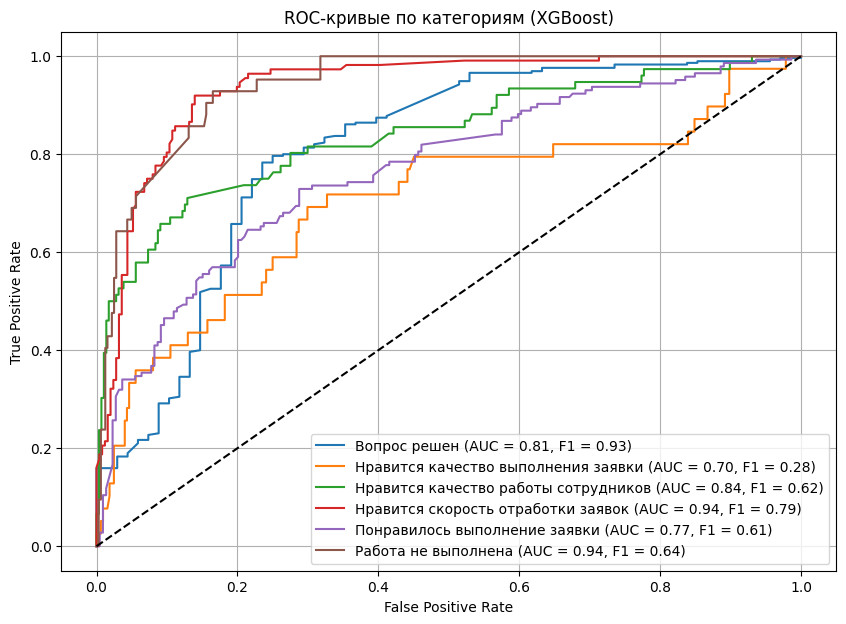

In [35]:
plt.figure(figsize=(10, 7))

for i, class_name in enumerate(Y.columns):
    plt.plot(fpr[i], tpr[i], label=f"{class_name} (AUC = {roc_auc_per_class[i]:.2f}, F1 = {f1_scores[class_name]:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривые по категориям (XGBoost)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
